In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import subprocess
from sherpa.astro.ui import *
from astropy.io import fits
from astropy.wcs import WCS

Loaded 5 candidate(s) from output/candidates/new_fxrt_w0.2_final_candidates.csv

=== ObsID 28964 | Using acisf28964N001_evt2.fits ===
RA=244.71667, DEC=-1.99176
 Photons within R90 (1.86" radius): 8
 Photons within 1.5×R90 (2.78" radius): 11
✅ Saved light curve figure to: complete74_candidate_figures/energy_vs_time/lc_28964_sig6.603705406188965.png


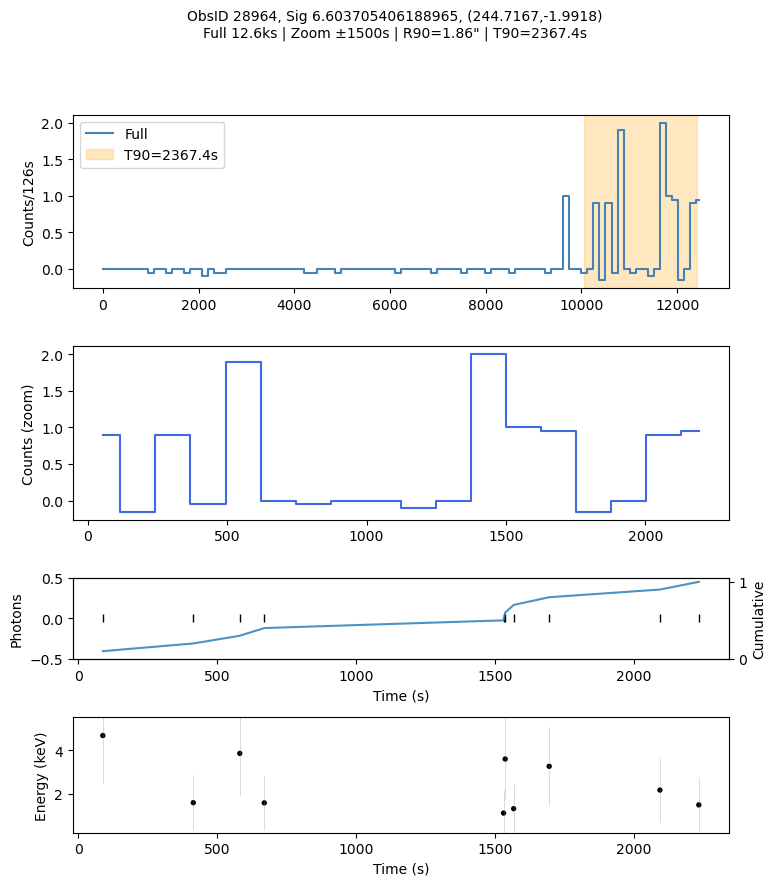

✅ Saved full energy-time figure to: complete74_candidate_figures/energy_vs_time/energy_full_28964_sig6.603705406188965.png


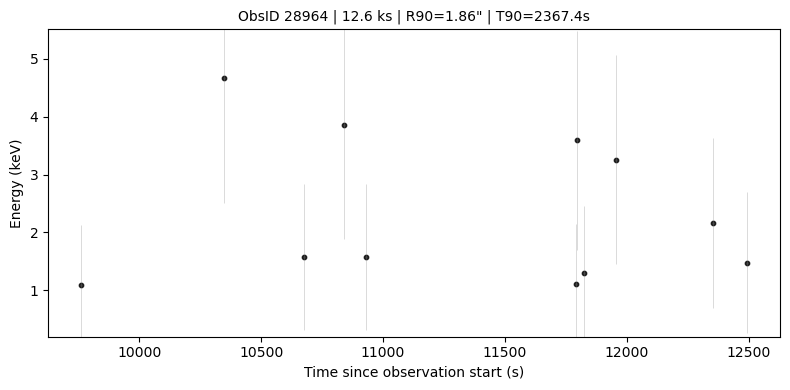

✅ Saved full scatter light curve to: complete74_candidate_figures/lightcurves/counts_vs_time_final_28964.png


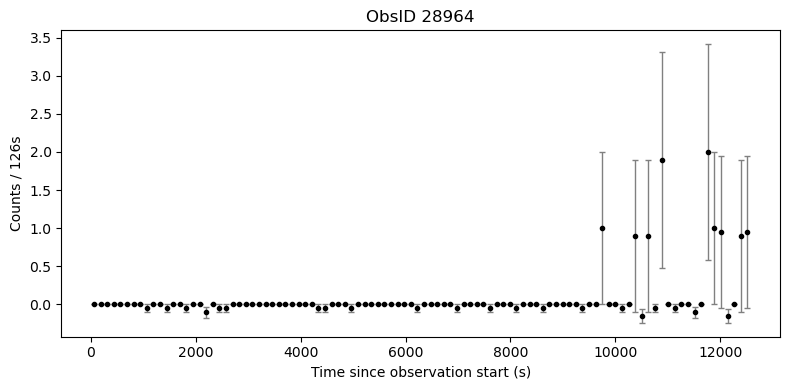

✅ Saved zoomed-in photon counts vs time plot to: complete74_candidate_figures/lightcurves/counts_vs_time_zoom_28964.png


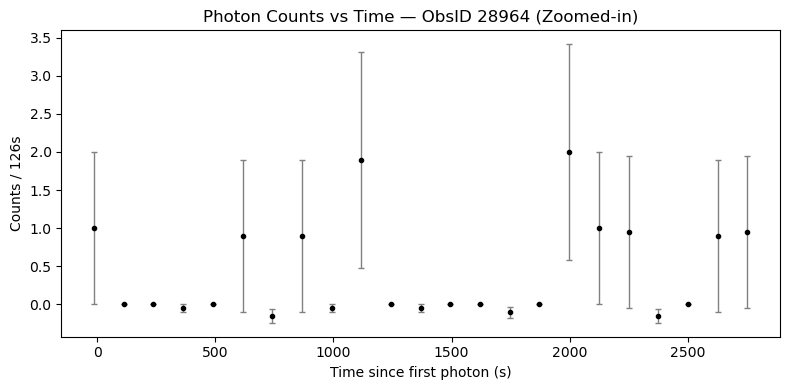

✅ Saved photon spectrum to: complete74_candidate_figures/spectra/counts_vs_energy_28964_final.png


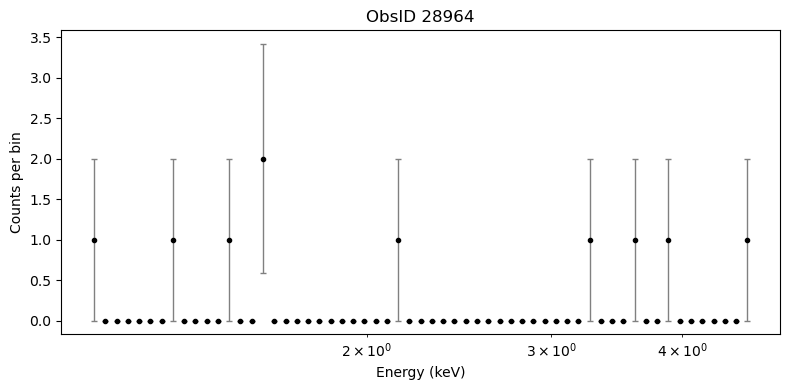

✅ Saved source pixel coordinates to: detections/source_pixel_coords.csv
    X_src=4480.30, Y_src=3455.79, R90=1.86", radius=2.78"

=== ObsID 30892 | Using acisf30892N001_evt2.fits ===
RA=192.74270, DEC=-6.56878
 Photons within R90 (3.21" radius): 12
 Photons within 1.5×R90 (4.81" radius): 23
✅ Saved light curve figure to: complete74_candidate_figures/energy_vs_time/lc_30892_sig11.262083053588867.png


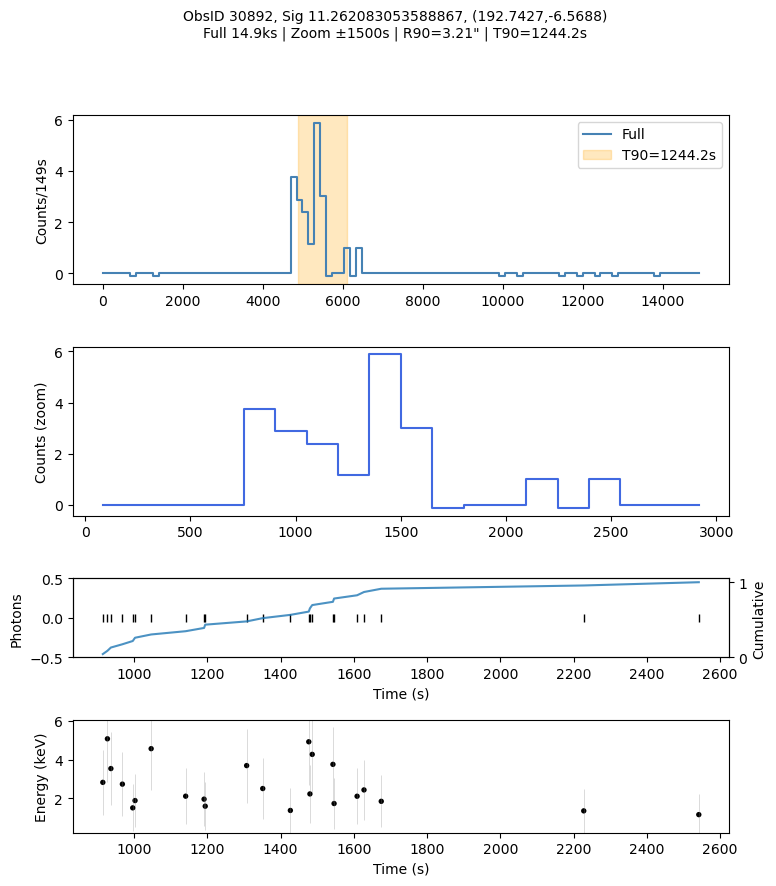

✅ Saved full energy-time figure to: complete74_candidate_figures/energy_vs_time/energy_full_30892_sig11.262083053588867.png


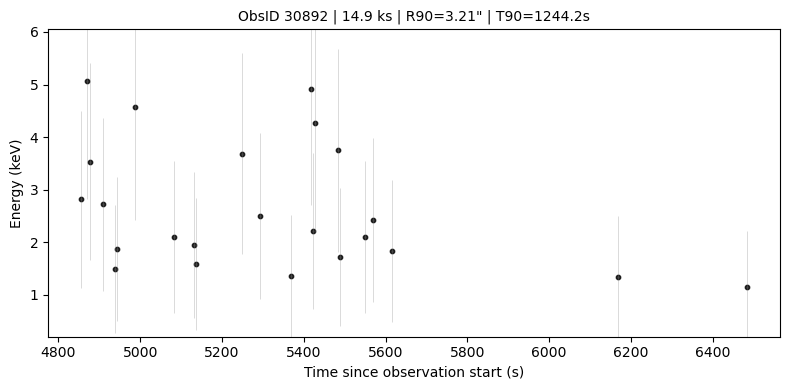

✅ Saved full scatter light curve to: complete74_candidate_figures/lightcurves/counts_vs_time_final_30892.png


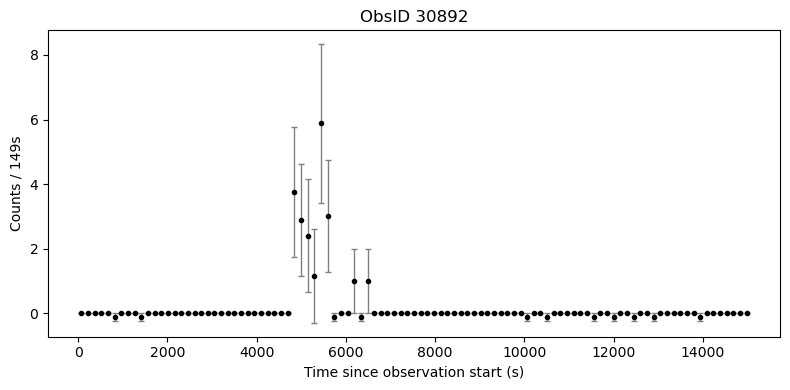

✅ Saved zoomed-in photon counts vs time plot to: complete74_candidate_figures/lightcurves/counts_vs_time_zoom_30892.png


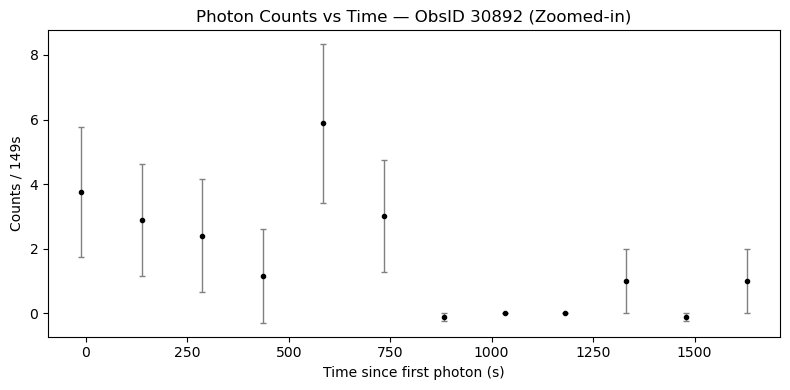

✅ Saved photon spectrum to: complete74_candidate_figures/spectra/counts_vs_energy_30892_final.png


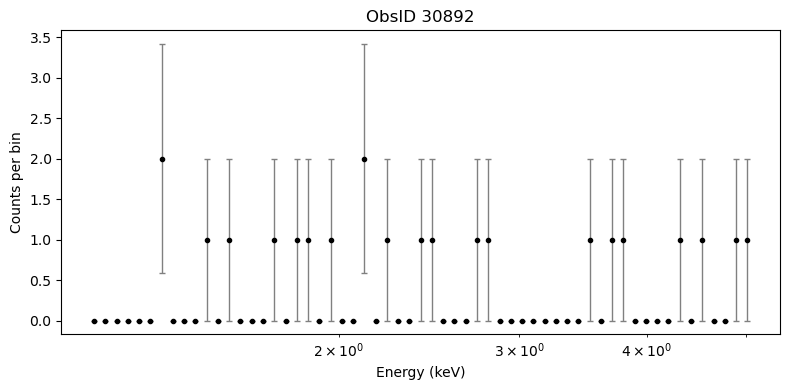

✅ Saved source pixel coordinates to: detections/source_pixel_coords.csv
    X_src=4154.67, Y_src=2973.77, R90=3.21", radius=4.81"

=== ObsID 18927 | Using acisf18927N003_evt2.fits ===
RA=83.87394, DEC=-4.99738
 Photons within R90 (0.34" radius): 5
 Photons within 1.5×R90 (0.51" radius): 11
✅ Saved light curve figure to: complete74_candidate_figures/energy_vs_time/lc_18927_sig11.376157760620115.png


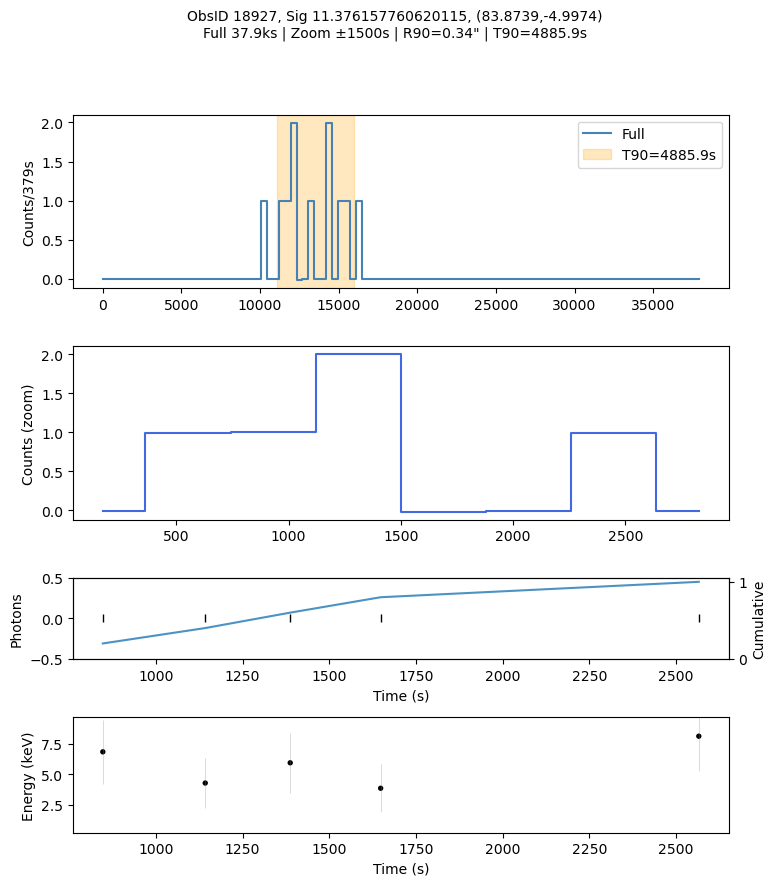

✅ Saved full energy-time figure to: complete74_candidate_figures/energy_vs_time/energy_full_18927_sig11.376157760620115.png


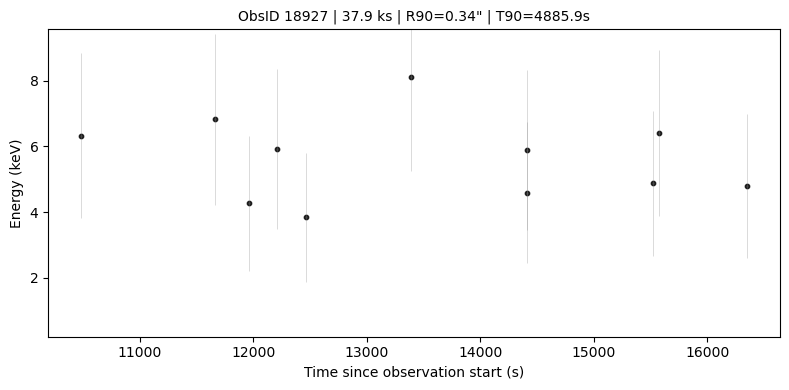

✅ Saved full scatter light curve to: complete74_candidate_figures/lightcurves/counts_vs_time_final_18927.png


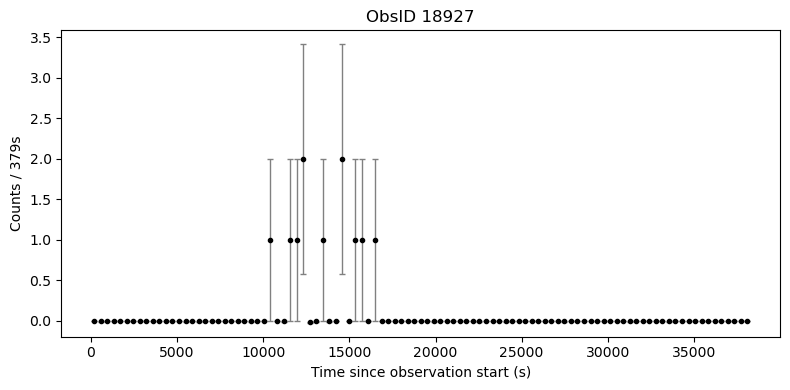

✅ Saved zoomed-in photon counts vs time plot to: complete74_candidate_figures/lightcurves/counts_vs_time_zoom_18927.png


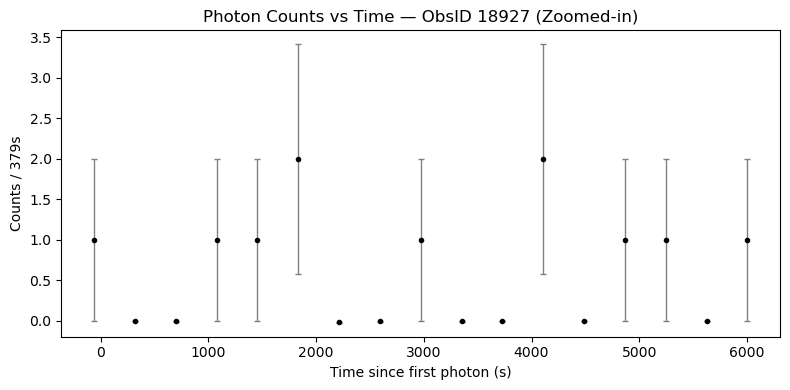

✅ Saved photon spectrum to: complete74_candidate_figures/spectra/counts_vs_energy_18927_final.png


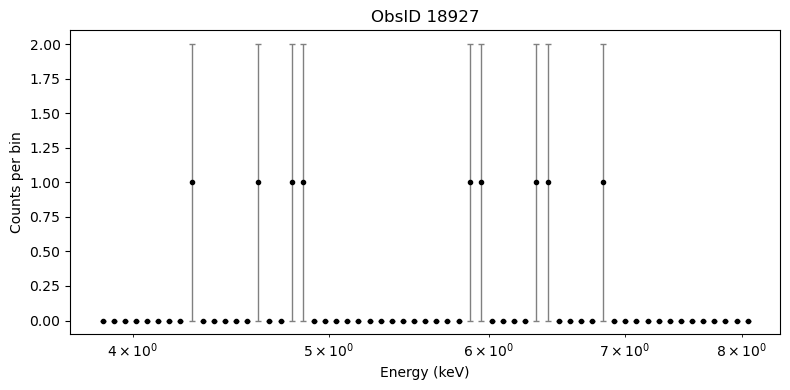

✅ Saved source pixel coordinates to: detections/source_pixel_coords.csv
    X_src=4119.90, Y_src=4111.12, R90=0.34", radius=0.51"

=== ObsID 29128 | Using acisf29128N001_evt2.fits ===
RA=83.83330, DEC=-5.42058
 Photons within R90 (0.58" radius): 15
 Photons within 1.5×R90 (0.88" radius): 27
✅ Saved light curve figure to: complete74_candidate_figures/energy_vs_time/lc_29128_sig17.386167526245117.png


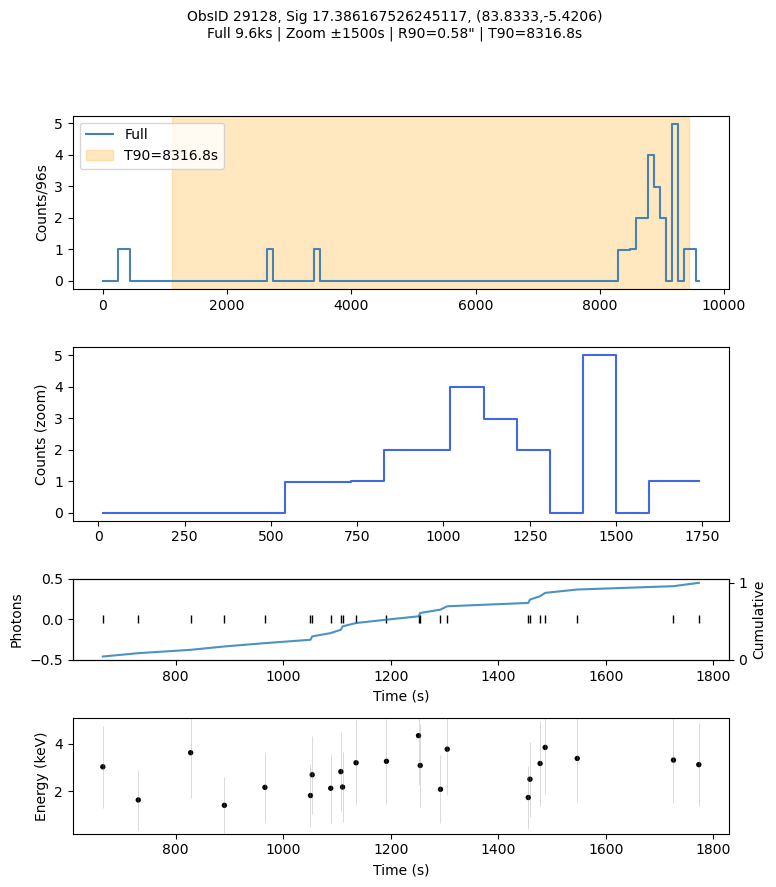

✅ Saved full energy-time figure to: complete74_candidate_figures/energy_vs_time/energy_full_29128_sig17.386167526245117.png


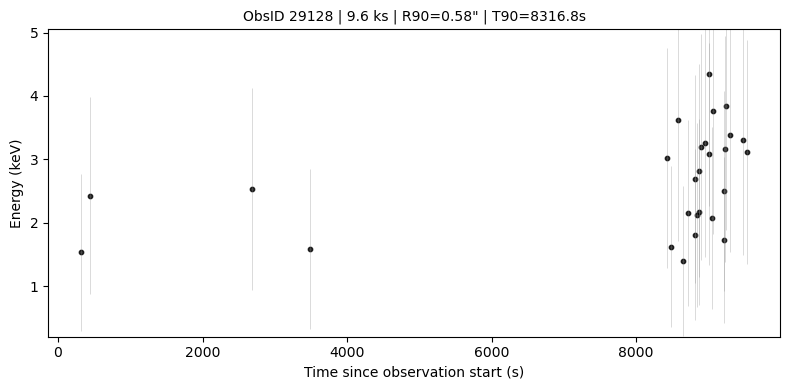

✅ Saved full scatter light curve to: complete74_candidate_figures/lightcurves/counts_vs_time_final_29128.png


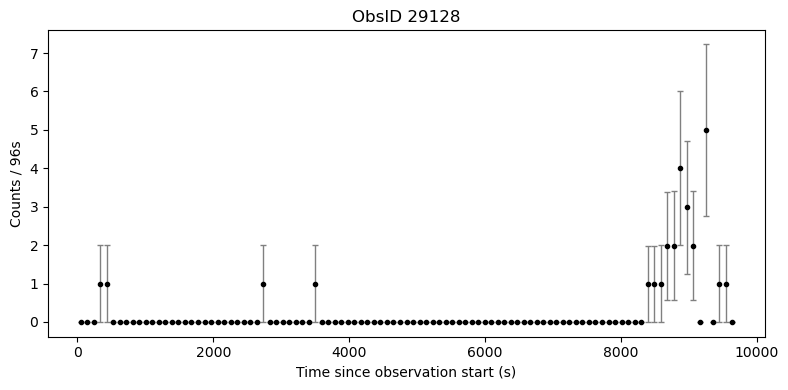

✅ Saved zoomed-in photon counts vs time plot to: complete74_candidate_figures/lightcurves/counts_vs_time_zoom_29128.png


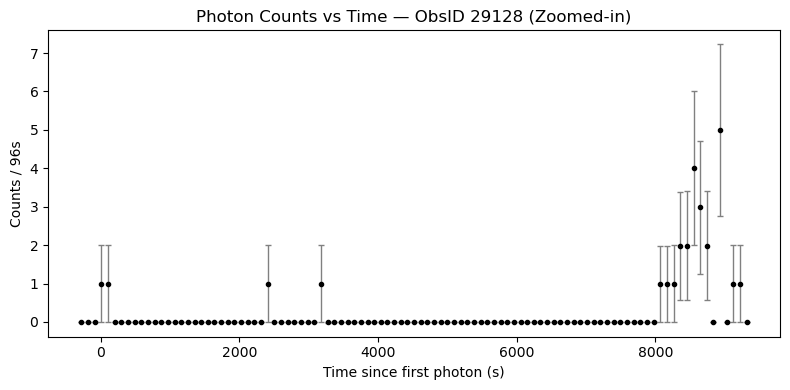

✅ Saved photon spectrum to: complete74_candidate_figures/spectra/counts_vs_energy_29128_final.png


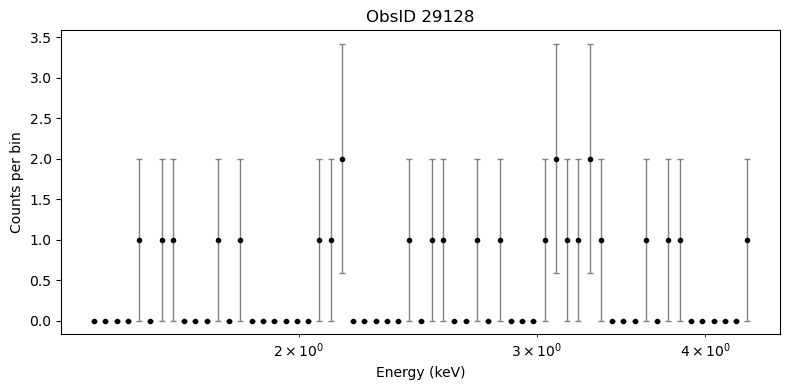

✅ Saved source pixel coordinates to: detections/source_pixel_coords.csv
    X_src=4030.05, Y_src=3902.90, R90=0.58", radius=0.88"

=== ObsID 1463 | Using acisf01463N007_evt2.fits ===
RA=24.68360, DEC=8.70850
 Photons within R90 (0.61" radius): 9
 Photons within 1.5×R90 (0.91" radius): 12
✅ Saved light curve figure to: complete74_candidate_figures/energy_vs_time/lc_1463_sig9.695898056030272.png


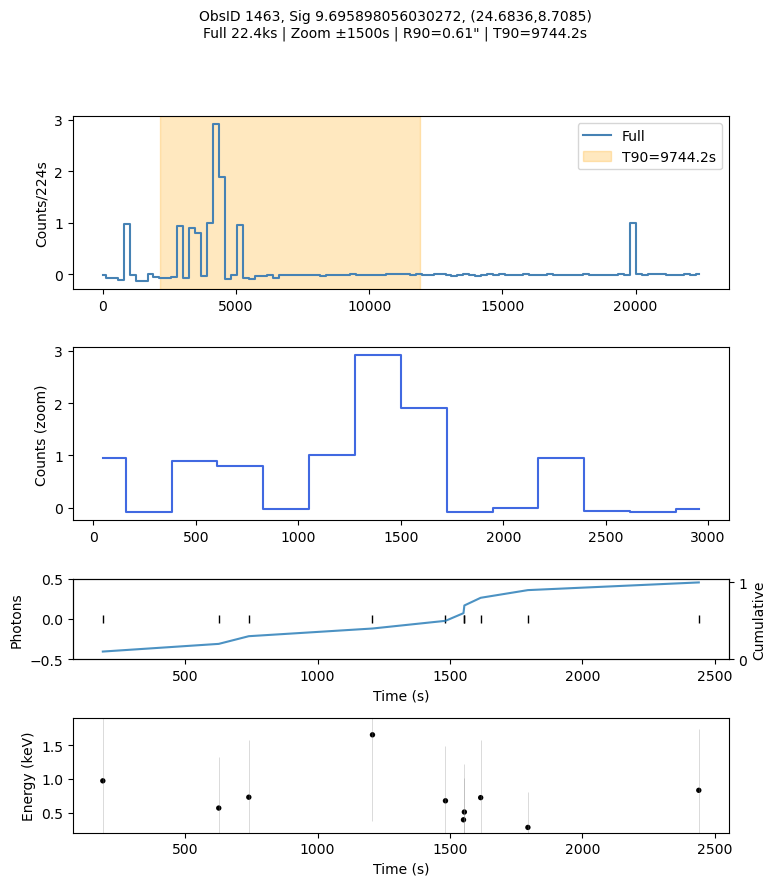

✅ Saved full energy-time figure to: complete74_candidate_figures/energy_vs_time/energy_full_1463_sig9.695898056030272.png


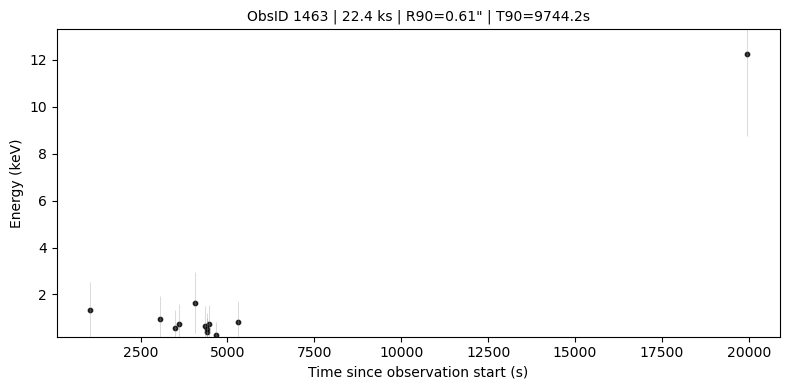

✅ Saved full scatter light curve to: complete74_candidate_figures/lightcurves/counts_vs_time_final_1463.png


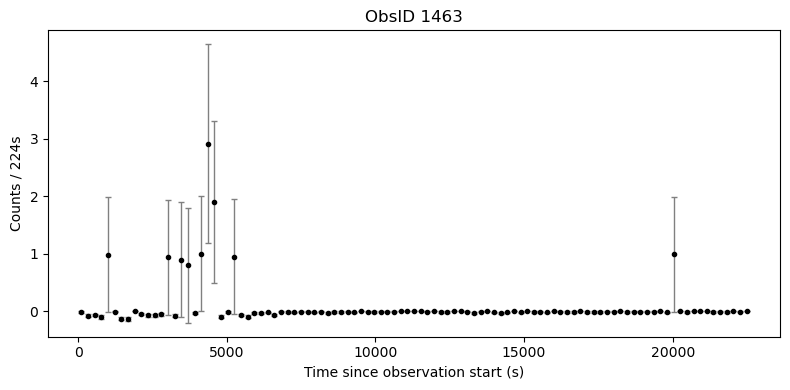

✅ Saved zoomed-in photon counts vs time plot to: complete74_candidate_figures/lightcurves/counts_vs_time_zoom_1463.png


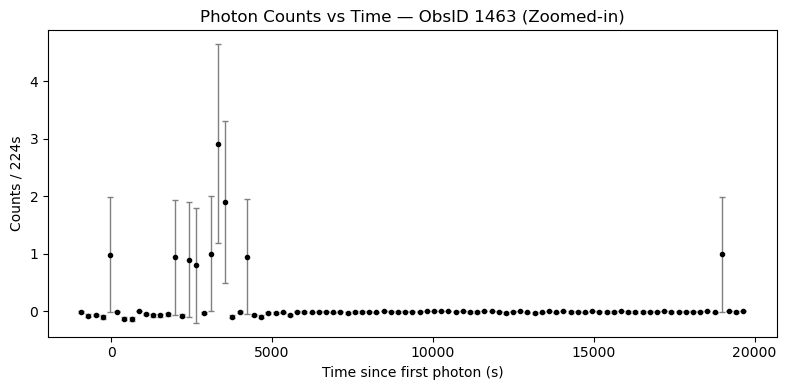

✅ Saved photon spectrum to: complete74_candidate_figures/spectra/counts_vs_energy_1463_final.png


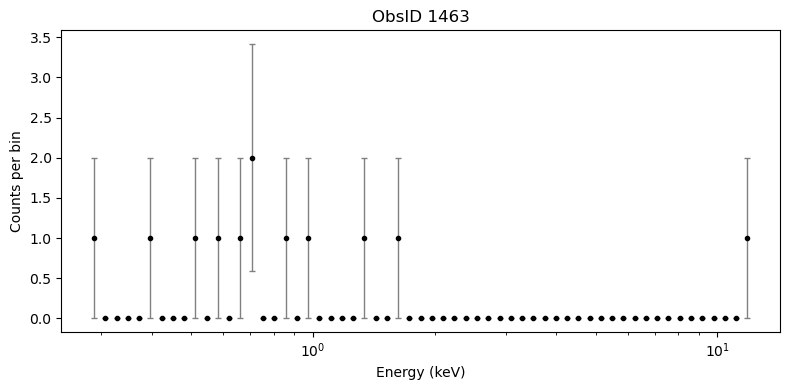

✅ Saved source pixel coordinates to: detections/source_pixel_coords.csv
    X_src=4090.03, Y_src=4313.90, R90=0.61", radius=0.91"


In [3]:

# ------------------------------------------------
# Estimate R90 from off-axis angle (arcmin)
# ------------------------------------------------
def estimate_R90(ra_deg, dec_deg, hdr):
    """Empirical Chandra PSF R90 (arcsec) from off-axis angle (arcmin)."""
    ra_pnt, dec_pnt = hdr.get("RA_PNT"), hdr.get("DEC_PNT")
    if ra_pnt is None or dec_pnt is None:
        return 1.0
    src = SkyCoord(ra_deg, dec_deg, unit="deg")
    pnt = SkyCoord(ra_pnt, dec_pnt, unit="deg")
    theta = src.separation(pnt).arcmin
    return 0.31 + 0.13 * theta + 0.020 * theta**2



# ------------------------------------------------
# Main function
# ------------------------------------------------
def extract_lightcurve(evtfile, ra, dec, obsid=None, significance=None,
                       binsize=5, plot=True, zoom_halfwidth=1500,
                       show_region=True):
    """
    PSF-adaptive light-curve extraction and global T90 calculation.
    Plots an additional region map showing source & background areas.
    """
    # Load event data
    with fits.open(evtfile) as hdul:
        events_hdu = hdul["EVENTS"] if "EVENTS" in hdul else hdul[1]
        hdr = events_hdu.header
        events = Table(events_hdu.data)
        rename = {c: c.lower() for c in events.colnames}
        events.rename_columns(list(rename.keys()), list(rename.values()))
        colnames = events.colnames
        times = np.array(events["time"])

        # PSF-adaptive aperture
        R90 = estimate_R90(ra, dec, hdr)
        radius_arcsec = 1.5 * R90
        bkg_annulus = (radius_arcsec, radius_arcsec + 20 * 0.492)

        # ------------------------------------------------
        # Count photons within R90 and within extraction radius (1.5 * R90)
        # ------------------------------------------------
        if "ra" in events.colnames and "dec" in events.colnames:
            ras, decs = np.array(events["ra"]), np.array(events["dec"])
            c_src = SkyCoord(ra*u.deg, dec*u.deg)
            c_evt = SkyCoord(ras*u.deg, decs*u.deg)
            sep_arcsec = c_src.separation(c_evt).arcsec
            n_within_R90 = np.sum(sep_arcsec < R90)
            n_within_ap = np.sum(sep_arcsec < radius_arcsec)
        else:
            x, y = np.array(events["x"]), np.array(events["y"])
            def g(k,a): return hdr.get(k, hdr.get(a))
            crpix1, crval1, cdelt1 = g("TCRPX11","CRPIX1"), g("TCRVL11","CRVAL1"), g("TCDLT11","CDELT1")
            crpix2, crval2, cdelt2 = g("TCRPX12","CRPIX2"), g("TCRVL12","CRVAL2"), g("TCDLT12","CDELT2")
            x_src = crpix1 + (ra-crval1)/cdelt1
            y_src = crpix2 + (dec-crval2)/cdelt2
            pixscale = np.sqrt(abs(cdelt1*cdelt2))*3600
            r_pix_R90 = R90/pixscale
            r_pix_ap = radius_arcsec/pixscale
            sep_pix = np.hypot(x-x_src, y-y_src)
            n_within_R90 = np.sum(sep_pix < r_pix_R90)
            n_within_ap = np.sum(sep_pix < r_pix_ap)
        
        print(f" Photons within R90 ({R90:.2f}\" radius): {n_within_R90}")
        print(f" Photons within 1.5×R90 ({radius_arcsec:.2f}\" radius): {n_within_ap}")

        # Spatial selection
        use_sky = ("ra" in colnames and "dec" in colnames)
        if use_sky:
            ras, decs = np.array(events["ra"]), np.array(events["dec"])
            c_src = SkyCoord(ra*u.deg, dec*u.deg)
            c_evt = SkyCoord(ras*u.deg, decs*u.deg)
            sep = c_src.separation(c_evt).arcsec
            src_mask = sep < radius_arcsec
            bkg_mask = (sep >= bkg_annulus[0]) & (sep <= bkg_annulus[1])
        else:
            x, y = np.array(events["x"]), np.array(events["y"])
            def g(k,a): return hdr.get(k, hdr.get(a))
            crpix1, crval1, cdelt1 = g("TCRPX11","CRPIX1"), g("TCRVL11","CRVAL1"), g("TCDLT11","CDELT1")
            crpix2, crval2, cdelt2 = g("TCRPX12","CRPIX2"), g("TCRVL12","CRVAL2"), g("TCDLT12","CDELT2")
            x_src = crpix1 + (ra-crval1)/cdelt1
            y_src = crpix2 + (dec-crval2)/cdelt2
            pixscale = np.sqrt(abs(cdelt1*cdelt2))*3600
            r_pix = radius_arcsec/pixscale
            ann_pix = (bkg_annulus[0]/pixscale, bkg_annulus[1]/pixscale)
            sep = np.hypot(x-x_src, y-y_src)
            src_mask = sep < r_pix
            bkg_mask = (sep >= ann_pix[0]) & (sep <= ann_pix[1])

    # Photons
    src_times = times[src_mask]
    bkg_times = times[bkg_mask]
    if len(src_times) == 0:
        print(f"⚠️ No photons within {radius_arcsec:.2f}\" for {os.path.basename(evtfile)}")
        return None
    tmin, tmax = times.min(), times.max()
    duration = tmax - tmin  # seconds

    # Adaptive binning
    bin_goal = 100
    binsize = max(5.0, duration/bin_goal)
    bins = np.arange(tmin, tmax+binsize, binsize)
    src_counts,_ = np.histogram(src_times,bins=bins)
    bkg_counts,_ = np.histogram(bkg_times,bins=bins)
    A_src = radius_arcsec**2
    A_bkg = bkg_annulus[1]**2 - bkg_annulus[0]**2
    net_counts = src_counts - bkg_counts * (A_src / A_bkg)

    # Global T90
    t_all = np.sort(src_times)
    T90,t5,t95 = None,None,None
    if len(t_all) >= 3:
        t5,t95 = np.percentile(t_all,[5,95])
        T90 = t95 - t5

    # --------------
    # BEGIN flare

   
    # -------------
    # END flare 
    # --------------

    
    # Zoom window
    if np.any(net_counts > 0):
        pk = np.argmax(net_counts)
        t_center = 0.5*(bins[pk]+bins[pk+1])
    else:
        t_center = np.median(src_times)
    zoom_start,zoom_end = max(tmin,t_center-zoom_halfwidth),min(tmax,t_center+zoom_halfwidth)
    mask_z = (bins[:-1]>=zoom_start)&(bins[:-1]<=zoom_end)
    bins_z,counts_z = bins[:-1][mask_z],net_counts[mask_z]
    times_z = np.sort(src_times[(src_times>=zoom_start)&(src_times<=zoom_end)])

    # Plot LC + CDF + Energy (zoom)
    if plot:
        fig,axes = plt.subplots(4,1,figsize=(8,9),
                                gridspec_kw={'height_ratios':[3,3,1.4,2]})
        axes[0].step(bins[:-1]-tmin,net_counts,where='mid',color='steelblue',label='Full')
        if T90: axes[0].axvspan(t5-tmin,t95-tmin,color='orange',alpha=0.25,label=f"T90={T90:.1f}s")
        axes[0].set_ylabel(f"Counts/{binsize:.0f}s"); axes[0].legend()

        if len(bins_z)>1 and np.any(counts_z>0):
            axes[1].step(bins_z-zoom_start,counts_z,where='mid',color='royalblue')
            axes[1].set_ylabel("Counts (zoom)")
        else:
            axes[1].text(0.5,0.5,"Too few photons",transform=axes[1].transAxes,ha='center')

        rel=times_z-zoom_start; axes[2].plot(rel,np.zeros_like(rel),'|',color='k')
        axes[2].set_ylabel("Photons"); axes[2].set_ylim(-0.5,0.5); axes[2].set_xlabel("Time (s)")
        ax2b=axes[2].twinx()
        if len(times_z): ax2b.plot(rel,np.arange(1,len(times_z)+1)/len(times_z),'-',lw=1.5,alpha=0.8)
        ax2b.set_ylabel("Cumulative"); ax2b.set_ylim(0,1.05)

        # Energy-time scatter (zoomed)
        if "energy" in colnames:
            E=np.array(events["energy"][src_mask])/1000.
        elif "pi" in colnames:
            E=np.array(events["pi"][src_mask])*0.0146
        else:E=np.zeros_like(src_times)
        mE=(src_times>=zoom_start)&(src_times<=zoom_end)
        axes[3].scatter(src_times[mE]-zoom_start,E[mE],s=15,color='black',edgecolor='none')
        axes[3].errorbar(src_times[mE]-zoom_start,E[mE],
                         yerr=np.sqrt(E[mE]), fmt='none', ecolor='gray', alpha=0.4, lw=0.5)
        axes[3].set_ylabel("Energy (keV)"); axes[3].set_xlabel("Time (s)")
        axes[3].set_ylim(0.2,max(0.5,np.percentile(E[mE],99)*1.2) if len(E[mE]) else 5)

        title=f"ObsID {obsid}, Sig {significance}, ({ra:.4f},{dec:.4f})"
        sub=(f"Full {duration/1000:.1f}ks | Zoom ±{zoom_halfwidth}s | R90={R90:.2f}\" | T90={T90:.1f}s" if T90 else "T90=n/a")
        fig.suptitle(title+"\n"+sub,fontsize=10)
        plt.tight_layout(rect=[0,0,1,0.93])

        # --- SAVE LIGHT CURVE FIGURE ---
        outdir = "complete74_candidate_figures/energy_vs_time"
        os.makedirs(outdir, exist_ok=True)
        fname = f"{outdir}/lc_{obsid}_sig{significance}.png"
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        print(f"✅ Saved light curve figure to: {fname}")

        plt.show()

        # ------------------------------------------------
        # New: Energy vs Time scatter for FULL light curve only
        # ------------------------------------------------
        if "energy" in colnames:
            E_full = np.array(events["energy"][src_mask]) / 1000.0
        elif "pi" in colnames:
            E_full = np.array(events["pi"][src_mask]) * 0.0146
        else:
            E_full = np.zeros_like(src_times)

        plt.figure(figsize=(8, 4))
        plt.scatter(src_times - tmin, E_full, s=10, color='black', alpha=0.8)
        plt.errorbar(src_times - tmin, E_full, yerr=np.sqrt(E_full),
                     fmt='none', ecolor='gray', alpha=0.4, lw=0.5)
        plt.xlabel("Time since observation start (s)")
        plt.ylabel("Energy (keV)")
        plt.ylim(0.2, max(0.5, np.percentile(E_full, 99)*1.2) if len(E_full) else 5)

        # Title: ObsID, exposure time, R90, T90
        exp_ks = duration / 1000
        plt.title(f"ObsID {obsid} | {exp_ks:.1f} ks | R90={R90:.2f}\" | T90={T90:.1f}s" if T90 else
                  f"ObsID {obsid} | {exp_ks:.1f} ks | R90={R90:.2f}\" | T90=n/a", fontsize=10)

        plt.tight_layout()
        fname = f"{outdir}/energy_full_{obsid}_sig{significance}.png"
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        print(f"✅ Saved full energy-time figure to: {fname}")
        plt.show()

    # ------------------------------------------------
    # Region map (sky or detector coordinates)
    # ------------------------------------------------
    if show_region:
        plt.figure(figsize=(7, 7))

        # Use RA/DEC if available, else fall back to detector coordinates
        if "ra" in events.colnames and "dec" in events.colnames:
            xvals, yvals = events["ra"], events["dec"]
            xlabel, ylabel = "RA (deg)", "DEC (deg)"
            invert_x = True
            # radii in degrees
            r90_deg = R90 / 3600.0
            radius_deg = (1.5 * R90) / 3600.0  # actual extraction region
            bkg_inner_deg = bkg_annulus[0] / 3600.0
            bkg_outer_deg = bkg_annulus[1] / 3600.0
            x0, y0 = ra, dec
        else:
            # Detector coordinates fallback
            xvals, yvals = events["x"], events["y"]
            xlabel, ylabel = "X (pixel)", "Y (pixel)"
            invert_x = False
            def g(k,a): return hdr.get(k, hdr.get(a))
            cdelt1 = g("TCDLT11", "CDELT1")
            cdelt2 = g("TCDLT12", "CDELT2")
            pixscale = np.sqrt(abs(cdelt1 * cdelt2)) * 3600  # arcsec/pix
            r90_pix = R90 / pixscale
            radius_pix = (1.5 * R90) / pixscale
            bkg_inner_pix = bkg_annulus[0] / pixscale
            bkg_outer_pix = bkg_annulus[1] / pixscale
            crpix1, crval1, cdelt1 = g("TCRPX11","CRPIX1"), g("TCRVL11","CRVAL1"), g("TCDLT11","CDELT1")
            crpix2, crval2, cdelt2 = g("TCRPX12","CRPIX2"), g("TCRVL12","CRVAL2"), g("TCDLT12","CDELT2")
            x0 = crpix1 + (ra - crval1)/cdelt1
            y0 = crpix2 + (dec - crval2)/cdelt2

        plt.scatter(xvals, yvals, s=1, alpha=0.3, label="events")

        ax = plt.gca()

        # --- Source region (1.5×R90) ---
        if "ra" in events.colnames:
            src_circle = plt.Circle((x0, y0), radius_deg, color="orange", lw=2, fill=False, label=f"1.5×R90 ({1.5*R90:.2f}\")")
            psf_circle = plt.Circle((x0, y0), r90_deg, color="orange", lw=1, ls="--", fill=False, alpha=0.6, label=f"R90 ({R90:.2f}\")")
            inner_circle = plt.Circle((x0, y0), bkg_inner_deg, color="gray", lw=1.5, fill=False, ls="--")
            outer_circle = plt.Circle((x0, y0), bkg_outer_deg, color="gray", lw=1.5, fill=False, ls="--", label="background annulus")
            pad = bkg_outer_deg * 3.0
            ax.set_xlim(x0 + np.array([1, -1]) * pad)
            ax.set_ylim(y0 + np.array([-1, 1]) * pad)
        else:
            src_circle = plt.Circle((x0, y0), radius_pix, color="orange", lw=2, fill=False, label=f"1.5×R90 ({1.5*R90:.2f}\")")
            psf_circle = plt.Circle((x0, y0), r90_pix, color="orange", lw=1, ls="--", fill=False, alpha=0.6, label=f"R90 ({R90:.2f}\")")
            inner_circle = plt.Circle((x0, y0), bkg_inner_pix, color="gray", lw=1.5, fill=False, ls="--")
            outer_circle = plt.Circle((x0, y0), bkg_outer_pix, color="gray", lw=1.5, fill=False, ls="--", label="background annulus")
            pad = bkg_outer_pix * 3.0
            ax.set_xlim(x0 + np.array([1, -1]) * pad)
            ax.set_ylim(y0 + np.array([-1, 1]) * pad)

        for c in [src_circle, psf_circle, inner_circle, outer_circle]:
            ax.add_patch(c)

        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(f"Extraction Regions — ObsID {obsid}")
        ax.legend(loc="upper right")
        if invert_x:
            plt.gca().invert_xaxis()

        plt.tight_layout()

        outdir = "complete74_candidate_figures/regions"
        os.makedirs(outdir, exist_ok=True)
        fname = f"{outdir}/region_{obsid}.png"
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        print(f"✅ Saved region map to: {fname}")

        plt.show()



    # ------------------------------------------------
    # Additional diagnostic scatter plots:
    #  1) Photon counts vs. time (adaptive bins)
    #  2) Photon counts vs. energy (spectrum)
    # ------------------------------------------------
    # ------------------------------------------------
    # Diagnostic scatter plots:
    #  1) Photon counts vs time (full)
    #  2) Photon counts vs time (zoomed-in)
    #  3) Photon counts vs energy (spectrum)
    # ------------------------------------------------
    if plot:
        outdir = "complete74_candidate_figures"
        os.makedirs(outdir, exist_ok=True)
    
        # Shared quantities
        centers_time = 0.5 * (bins[1:] + bins[:-1])
        y_counts = src_counts - bkg_counts * (A_src / A_bkg)
        yerr = np.sqrt(src_counts + (bkg_counts * (A_src / A_bkg)**2))
    
        # ------------------------------------------------
        # 1️⃣ Photon counts vs time (full)
        # ------------------------------------------------
        plt.figure(figsize=(8, 4))
        plt.errorbar(
            centers_time - tmin, y_counts, yerr=yerr,
            fmt='o', color='black', ecolor='gray',
            elinewidth=1, capsize=2, markersize=3
        )
        plt.xlabel("Time since observation start (s)")
        plt.ylabel(f"Counts / {binsize:.0f}s")
        plt.title(f"ObsID {obsid}")
        plt.tight_layout()
        fname_time_full = f"{outdir}/lightcurves/counts_vs_time_final_{obsid}.png"
        plt.savefig(fname_time_full, dpi=300, bbox_inches='tight')
        print(f"✅ Saved full scatter light curve to: {fname_time_full}")
        plt.show()
    
        # ------------------------------------------------
        # 2️⃣ Photon counts vs time (zoomed-in)
        # ------------------------------------------------
        t_first = src_times.min()
        t_last = src_times.max()
        t_pad = 0.05 * (t_last - t_first)  # 5% padding before & after
    
        # Select bins covering [first - pad, last + pad]
        mask_zoom = (centers_time >= (t_first - t_pad)) & (centers_time <= (t_last + t_pad))
    
        plt.figure(figsize=(8, 4))
        plt.errorbar(
            centers_time[mask_zoom] - t_first,
            y_counts[mask_zoom],
            yerr=yerr[mask_zoom],
            fmt='o', color='black', ecolor='gray',
            elinewidth=1, capsize=2, markersize=3
        )
        plt.xlabel("Time since first photon (s)")
        plt.ylabel(f"Counts / {binsize:.0f}s")
        plt.title(f"Photon Counts vs Time — ObsID {obsid} (Zoomed-in)")
        plt.tight_layout()
        fname_time_zoom = f"{outdir}/lightcurves/counts_vs_time_zoom_{obsid}.png"
        plt.savefig(fname_time_zoom, dpi=300, bbox_inches='tight')
        print(f"✅ Saved zoomed-in photon counts vs time plot to: {fname_time_zoom}")
        plt.show()

        # ------------------------------------------------
        # 3️⃣ Photon counts vs energy (spectrum)
        # ------------------------------------------------
        if "energy" in colnames:
            E_full = np.array(events["energy"][src_mask]) / 1000.0  # keV
        elif "pi" in colnames:
            E_full = np.array(events["pi"][src_mask]) * 0.0146
        else:
            E_full = np.zeros_like(src_times)
    
        # Filter valid energies
        E_full = E_full[E_full > 0.05]
        nbins_E = 60
        bins_E = np.logspace(np.log10(E_full.min()), np.log10(E_full.max()), nbins_E)
        counts_E, _ = np.histogram(E_full, bins=bins_E)
        centers_E = np.sqrt(bins_E[1:] * bins_E[:-1])
        yerr_E = np.sqrt(counts_E)
    
        plt.figure(figsize=(8, 4))
        plt.errorbar(
            centers_E, counts_E, yerr=yerr_E,
            fmt='o', color='black', ecolor='gray',
            elinewidth=1, capsize=2, markersize=3
        )
        plt.xscale("log")
        plt.yscale("linear")
        plt.xlabel("Energy (keV)")
        plt.ylabel("Counts per bin")
        plt.title(f"ObsID {obsid}")
        plt.tight_layout()
        fname_E = f"{outdir}/spectra/counts_vs_energy_{obsid}_final.png"
        plt.savefig(fname_E, dpi=300, bbox_inches='tight')
        print(f"✅ Saved photon spectrum to: {fname_E}")
        plt.show()

        # ------------------------------------------------
        # Save derived source pixel coordinates for flux extraction
        # ------------------------------------------------
        try:
            outdir = "detections"
            os.makedirs(outdir, exist_ok=True)
            coords_file = os.path.join(outdir, "source_pixel_coords.csv")
    
            # Check if file exists
            file_exists = os.path.exists(coords_file)
    
            # Append one line per candidate (ObsID, RA, DEC, X, Y, R90, radius_arcsec)
            with open(coords_file, "a") as f:
                # Write header only once
                if not file_exists:
                    f.write("ObsID,RA,DEC,X_src,Y_src,R90_arcsec,Radius_arcsec\n")
                f.write(f"{obsid},{ra:.6f},{dec:.6f},{x_src:.3f},{y_src:.3f},{R90:.3f},{radius_arcsec:.3f}\n")
    
            print(f"✅ Saved source pixel coordinates to: {coords_file}")
            print(f"    X_src={x_src:.2f}, Y_src={y_src:.2f}, R90={R90:.2f}\", radius={radius_arcsec:.2f}\"")
    
        except Exception as e:
            print(f"⚠️ Could not save source pixel coords for ObsID {obsid}: {e}")

       


       

# ===========================================
#  Run over all FXRT candidates
# ===========================================
data_root = "new_data"
candidates_file = "output/candidates/new_fxrt_w0.2_final_candidates.csv"   # list the 4 final candidates
#candidates_file = "output/candidates/new_fxrt_w0.2_possible.csv"   # lists all 58 candidate detections. 

candidates = pd.read_csv(candidates_file)
print(f"Loaded {len(candidates)} candidate(s) from {candidates_file}")

for _, row in candidates.iterrows():
    obsid = str(row["ObsId"]).strip()
    obsid_padded = obsid.zfill(5)
    ra, dec = float(row["RA"]), float(row["DEC"])
    significance = row.get("SIGNIFICANCE", "N/A")

    base_paths = [
        os.path.join(data_root, obsid, "repro"),
        os.path.join(data_root, obsid_padded, "repro"),
        os.path.join(data_root, "new_obsids_w0.2", obsid, "repro"),
        os.path.join(data_root, "new_obsids_w0.2", obsid_padded, "repro")
    ]

    matches = []
    for base in base_paths:
        pattern = os.path.join(base, f"acisf{obsid_padded}N*_evt2.fits")
        matches.extend(glob.glob(pattern))

    if len(matches) == 0:
        pattern_recursive = os.path.join(data_root, "**", f"acisf{obsid_padded}N*_evt2.fits")
        matches = glob.glob(pattern_recursive, recursive=True)

    if len(matches) == 0:
        print(f"⚠️ No event file found for ObsID {obsid}")
        continue

    evtfile = sorted(matches)[-1]
    print(f"\n=== ObsID {obsid} | Using {os.path.basename(evtfile)} ===")
    print(f"RA={ra:.5f}, DEC={dec:.5f}")

    try:
        extract_lightcurve(
            evtfile,
            ra, dec,
            obsid=obsid,
            significance=significance,
            binsize=5,
            zoom_halfwidth=1500,
            show_region=False
        )
    except Exception as e:
        print(f"❌ Error processing ObsID {obsid}: {e}")


In [5]:
# ===========================================
#  Photon timeline generator — no light curves
# ===========================================
import os
import glob
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time

# --- use your existing R90 estimator ---
def estimate_R90(ra_deg, dec_deg, hdr):
    """Empirical Chandra PSF R90 (arcsec) from off-axis angle (arcmin)."""
    ra_pnt, dec_pnt = hdr.get("RA_PNT"), hdr.get("DEC_PNT")
    if ra_pnt is None or dec_pnt is None:
        return 1.0
    src = SkyCoord(ra_deg, dec_deg, unit="deg")
    pnt = SkyCoord(ra_pnt, dec_pnt, unit="deg")
    theta = src.separation(pnt).arcmin
    return 0.31 + 0.13 * theta + 0.020 * theta**2


def generate_photon_timeline(evtfile, ra, dec, obsid=None, significance=None):
    """
    Create a photon-by-photon table inside 1.5×R90 of the source position.
    Includes photon times (UTC + relative), energies, and positions (RA/DEC/X/Y).
    """

    outdir_tbl = "detections/correct_photon_tables"
    os.makedirs(outdir_tbl, exist_ok=True)

    with fits.open(evtfile) as hdul:
        events_hdu = hdul["EVENTS"] if "EVENTS" in hdul else hdul[1]
        hdr = events_hdu.header
        events = Table(events_hdu.data)
        rename = {c: c.lower() for c in events.colnames}
        events.rename_columns(list(rename.keys()), list(rename.values()))
        colnames = events.colnames
        times = np.array(events["time"])

        # Absolute start time
        try:
            mjd_start = hdr.get("MJDREF", 0) + hdr.get("TSTART") / 86400.0
            t0 = Time(mjd_start, format="mjd")
        except Exception:
            t0 = None

        # R90 estimate and search radius
        R90 = estimate_R90(ra, dec, hdr)
        R_region = 1.5 * R90

        # Determine separations in arcsec
        if "ra" in colnames and "dec" in colnames:
            ras, decs = np.array(events["ra"]), np.array(events["dec"])
            c_src = SkyCoord(ra*u.deg, dec*u.deg)
            c_evt = SkyCoord(ras*u.deg, decs*u.deg)
            sep_arcsec = c_src.separation(c_evt).arcsec
        else:
            x, y = np.array(events["x"]), np.array(events["y"])
            def g(k,a): return hdr.get(k, hdr.get(a))
            crpix1, crval1, cdelt1 = g("TCRPX11","CRPIX1"), g("TCRVL11","CRVAL1"), g("TCDLT11","CDELT1")
            crpix2, crval2, cdelt2 = g("TCRPX12","CRPIX2"), g("TCRVL12","CRVAL2"), g("TCDLT12","CDELT2")
            x_src = crpix1 + (ra-crval1)/cdelt1
            y_src = crpix2 + (dec-crval2)/cdelt2
            pixscale = np.sqrt(abs(cdelt1*cdelt2))*3600
            sep_arcsec = np.hypot(x-x_src, y-y_src) * pixscale

        mask = sep_arcsec < R_region
        if not np.any(mask):
            print(f"⚠️ No photons within {R_region:.1f}\" for ObsID {obsid}")
            return None

        # Energies
        if "energy" in colnames:
            E_keV = np.array(events["energy"][mask]) / 1000.0
        elif "pi" in colnames:
            E_keV = np.array(events["pi"][mask]) * 0.0146
        else:
            E_keV = np.zeros_like(times[mask])

        # Sky & detector coordinates (if available)
        ra_vals = np.array(events["ra"][mask]) if "ra" in colnames else np.repeat(np.nan, np.sum(mask))
        dec_vals = np.array(events["dec"][mask]) if "dec" in colnames else np.repeat(np.nan, np.sum(mask))
        x_vals = np.array(events["x"][mask]) if "x" in colnames else np.repeat(np.nan, np.sum(mask))
        y_vals = np.array(events["y"][mask]) if "y" in colnames else np.repeat(np.nan, np.sum(mask))

        # Build DataFrame
        # Build DataFrame
        photon_times = times[mask]
        
        # Convert to UTC if possible
        if t0 is not None:
            utc_times = (t0 + photon_times * u.s).utc.isot
        else:
            utc_times = np.repeat("n/a", len(photon_times))
        
        # Construct timeline — use actual times since TSTART, not relative to first photon
        df = pd.DataFrame({
            "Photon#": np.arange(1, len(photon_times) + 1),
            "Time_s_since_obs_start": photon_times,   # <-- FIXED LINE
            "UTC": utc_times,
            "Energy_keV": np.round(E_keV, 3),
            "RA_deg": np.round(ra_vals, 6),
            "DEC_deg": np.round(dec_vals, 6),
            "X_pix": np.round(x_vals, 2),
            "Y_pix": np.round(y_vals, 2)
        })

        df.sort_values("Time_s_since_obs_start", inplace=True)


        fname = f"{outdir_tbl}/photons_{obsid}_sig{significance}.csv"
        df.to_csv(fname, index=False)
        print(f"✅ Saved photon timeline ({len(df)} photons) to: {fname}")
        print(f"  → Includes positions (RA/DEC and X/Y) inside 1.5×R90 ({R_region:.2f}\")")

        return df



# ===========================================
#  Run over all FXRT candidates — timelines only
# ===========================================
data_root = "new_data"
candidates_file = "output/candidates/new_fxrt_w0.2_final_candidates.csv"
candidates = pd.read_csv(candidates_file)
print(f"Loaded {len(candidates)} candidate(s) from {candidates_file}")

for _, row in candidates.iterrows():
    obsid = str(row["ObsId"]).strip()
    obsid_padded = obsid.zfill(5)
    ra, dec = float(row["RA"]), float(row["DEC"])
    significance = row.get("SIGNIFICANCE", "N/A")

    # Locate event file
    base_paths = [
        os.path.join(data_root, obsid, "repro"),
        os.path.join(data_root, obsid_padded, "repro"),
        os.path.join(data_root, "new_obsids_w0.2", obsid, "repro"),
        os.path.join(data_root, "new_obsids_w0.2", obsid_padded, "repro")
    ]
    matches = []
    for base in base_paths:
        matches.extend(glob.glob(os.path.join(base, f"acisf{obsid_padded}N*_evt2.fits")))

    if not matches:
        matches = glob.glob(os.path.join(data_root, "**", f"acisf{obsid_padded}N*_evt2.fits"), recursive=True)

    if not matches:
        print(f"⚠️ No event file found for ObsID {obsid}")
        continue

    evtfile = sorted(matches)[-1]
    print(f"\n=== ObsID {obsid} | Using {os.path.basename(evtfile)} ===")
    generate_photon_timeline(evtfile, ra, dec, obsid=obsid, significance=significance)


Loaded 5 candidate(s) from output/candidates/new_fxrt_w0.2_final_candidates.csv

=== ObsID 28964 | Using acisf28964N001_evt2.fits ===
✅ Saved photon timeline (11 photons) to: detections/correct_photon_tables/photons_28964_sig6.603705406188965.csv
  → Includes positions (RA/DEC and X/Y) inside 1.5×R90 (2.78")

=== ObsID 30892 | Using acisf30892N001_evt2.fits ===


/opt/anaconda3/envs/ciao/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 11 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/envs/ciao/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 11 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/envs/ciao/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 23 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/envs/ciao/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 23 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


✅ Saved photon timeline (23 photons) to: detections/correct_photon_tables/photons_30892_sig11.262083053588867.csv
  → Includes positions (RA/DEC and X/Y) inside 1.5×R90 (4.81")

=== ObsID 18927 | Using acisf18927N003_evt2.fits ===
✅ Saved photon timeline (11 photons) to: detections/correct_photon_tables/photons_18927_sig11.376157760620115.csv
  → Includes positions (RA/DEC and X/Y) inside 1.5×R90 (0.51")


/opt/anaconda3/envs/ciao/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 11 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/envs/ciao/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 11 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/envs/ciao/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 27 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/opt/anaconda3/envs/ciao/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 27 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)



=== ObsID 29128 | Using acisf29128N001_evt2.fits ===
✅ Saved photon timeline (27 photons) to: detections/correct_photon_tables/photons_29128_sig17.386167526245117.csv
  → Includes positions (RA/DEC and X/Y) inside 1.5×R90 (0.88")

=== ObsID 1463 | Using acisf01463N007_evt2.fits ===
✅ Saved photon timeline (12 photons) to: detections/correct_photon_tables/photons_1463_sig9.695898056030272.csv
  → Includes positions (RA/DEC and X/Y) inside 1.5×R90 (0.91")
